# Notebook to evaluate experimental results

To re-run, go to supplementary code and run all cells below.

## Pre-training

In [172]:
# Container to store images drawn in thesis - compare all k's
draw_store_cmp = {
    1: [],
    2: [],
    3: []
}

# Container to store images drawn in thesis - compare bad vs good results from best k
draw_store_bg = []
# Indices used to compare nets
cmp_indices = [300, 2, 505]

# Indices used to show good and bad results
bg_indices = [300, 2, 505]

### Resunet k=1

Setup

In [170]:
"""
Setup
Load mean, pre-processing function, import stuff
"""
from coco.architectures.depth import DepthPredictionScaffolder, ResidualDepth
from coco.transformations import zoom_rotate, random_rgb, random_crop, normalize_images, downsample, clip, noise, exp, flip_x

global mean
mean = np.load("/data/data/nyu_v2.npy")
def preprocess(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    global mean

    size = (228, 304)
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    images, labels = random_crop(images, labels, size, deterministic=True)
    images, labels = downsample(images, labels, (1, 2))

    return images, labels

In [171]:
"""
Load network and its weights
"""
scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True, k=1)

scaffolder.compile()
scaffolder.load("/data/data/resunet_thesis.npz")

INFO:coco.nn:Number of parameters for output 'None': 46054721
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_thesis.npz'


In [173]:
"""
Iterate through the test data and calculate metrics
"""
db = "/data/data/test_v2.hdf5"
f = h5py.File(db)

images_orig = np.array(f["images"])
depths_orig = np.array(f["depths"])

cropped_depths = []
predictions = []
eval_times = []

for index in range(images_orig.shape[0]):
    images = images_orig[index][np.newaxis]
    depths = depths_orig[index][np.newaxis]
    # Pre process
    images, depths = preprocess(images, depths)
    # Infer
    s = time.time()
    pred = scaffolder.infer(images)[0]
    eval_times.append(time.time() - s)
    
    # Post process
    pred = post_process_depth(pred)
        
    # Save some images for drawing in thesis
    if index in cmp_indices:
        draw_store_cmp[1].append((images_orig[index],depths,pred))
    
    cropped_depths.append(depths)
    predictions.append(pred)
    
gt = np.concatenate(cropped_depths).squeeze()
predictions = np.concatenate(predictions).squeeze()
print "Average eval time: ", np.array(eval_times).mean()

Average eval time:  0.0218318369046


In [81]:
calculate_depth_metrics(predictions, gt)

RMSE(lin)  0.739724
RMSE(log)  0.261472
Delta 1.25  0.716009919072
Delta 1.25**2  0.908257057217
Delta 1.25**3  0.970392442558
Abs rel diff  0.186323
Square rel diff  0.179227


In [ ]:
eval_times = []
for _ in range(100):
    # Doesn't really matter whether the data makes sense or not. Only looking at timings here
    s = time.time()
    sample = np.zeros((16, 3, 228, 304), dtype=np.float32)
    pred = scaffolder.infer(sample)[0]
    eval_times.append(time.time() - s)
    
print "Average eval time batch: ", np.array(eval_times).mean()

Plot

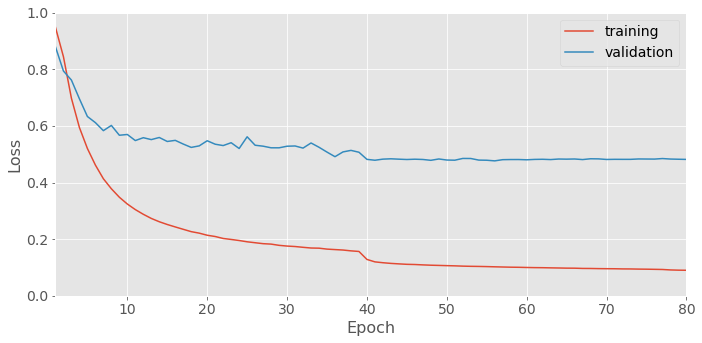

In [15]:
current_job = Job.from_name("nyu_depth_thesis")
current_job.load()
data = current_job.data
    
n_epochs = data["epoch"]
t_data = np.array(data["train_losses"]).squeeze()
v_data = np.array(data["val_losses"]).squeeze()    

t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)

_ = plt.figure(figsize=(10,5))
plt.plot(np.arange(n_epochs)+1, t_data, label="training")
plt.plot(np.arange(n_epochs)+1, v_data, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0,1))
plt.xlim(1, n_epochs)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("out/pretrain-k1.pdf", dpi=200)


### k = 0.5

In [174]:
"""
Load network and its weights
"""
scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True, k=0.5)

scaffolder.compile()
scaffolder.load("/data/data/resunet_half_thesis.npz")

INFO:coco.nn:Number of parameters for output 'None': 11541505
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_half_thesis.npz'


In [175]:
"""
Iterate through the test data and calculate metrics
"""
db = "/data/data/test_v2.hdf5"
f = h5py.File(db)

images_orig = np.array(f["images"])
depths_orig = np.array(f["depths"])

cropped_depths = []
predictions = []
eval_times = []

for index in range(images_orig.shape[0]):
    images = images_orig[index][np.newaxis]
    depths = depths_orig[index][np.newaxis]
    # Pre process
    images, depths = preprocess(images, depths)
    # Infer
    s = time.time()
    pred = scaffolder.infer(images)[0]
    eval_times.append(time.time() - s)

    
    # Post process
    pred = post_process_depth(pred)
    
    if index in cmp_indices:
        draw_store_cmp[2].append((images_orig[index],depths,pred))
        
    if index in bg_indices:
        draw_store_bg.append((images_orig[index], depths, pred))
    
    cropped_depths.append(depths)
    predictions.append(pred)
    
gt = np.concatenate(cropped_depths).squeeze()
predictions = np.concatenate(predictions).squeeze()
print "Average eval time: ", np.array(eval_times).mean()

Average eval time:  0.0107622463769


In [44]:
calculate_depth_metrics(predictions, gt)

RMSE(lin)  0.675034
RMSE(log)  0.239987
Delta 1.25  0.759299173917
Delta 1.25**2  0.92574100076
Delta 1.25**3  0.975950433584
Abs rel diff  0.164467
Square rel diff  0.145724


In [74]:
eval_times = []
for _ in range(100):
    # Doesn't really matter whether the data makes sense or not. Only looking at timings here
    s = time.time()
    sample = np.zeros((16, 3, 228, 304), dtype=np.float32)
    pred = scaffolder.infer(sample)[0]
    eval_times.append(time.time() - s)
    
print "Average eval time batch: ", np.array(eval_times).mean()

Average eval time batch:  0.0976216435432


#### Plot 

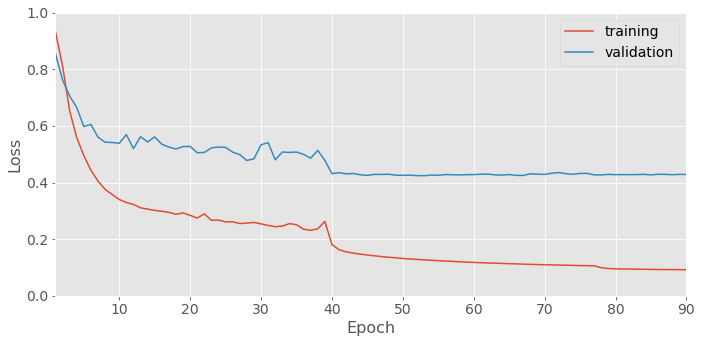

In [16]:
current_job = Job.from_name("nyu_depth_half_thesis")
current_job.load()
data = current_job.data

n_epochs = data["epoch"]
t_data = np.array(data["train_losses"]).squeeze()
v_data = np.array(data["val_losses"]).squeeze()    

t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)

_ = plt.figure(figsize=(10,5))
plt.plot(np.arange(n_epochs) + 1, t_data, label="training")
plt.plot(np.arange(n_epochs) + 1, v_data, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0,1))
plt.xlim(1, n_epochs)
plt.legend(loc='upper right')
plt.tight_layout()

plt.savefig("out/pretrain-k05.pdf", dpi=200)
    

### k = 0.25

In [176]:
"""
Load network and its weights
"""
scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True, k=0.25)

scaffolder.compile()
scaffolder.load("/data/data/resunet_quarter_thesis.npz")

INFO:coco.nn:Number of parameters for output 'None': 2902865
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_quarter_thesis.npz'


In [177]:
import time
"""
Iterate through the test data and calculate metrics
"""
db = "/data/data/test_v2.hdf5"
f = h5py.File(db)

images_orig = np.array(f["images"])
depths_orig = np.array(f["depths"])

cropped_depths = []
predictions = []
eval_times = []

for index in range(images_orig.shape[0]):
    images = images_orig[index][np.newaxis]
    depths = depths_orig[index][np.newaxis]
    # Pre process
    images, depths = preprocess(images, depths)
    # Infer
    s = time.time()
    pred = scaffolder.infer(images)[0]
    eval_times.append(time.time() - s)

    # Post process
    pred = post_process_depth(pred)
    
    if index in cmp_indices:
        draw_store_cmp[3].append((images_orig[index],depths,pred))
    
    cropped_depths.append(depths)
    predictions.append(pred)
    
gt = np.concatenate(cropped_depths).squeeze()
predictions = np.concatenate(predictions).squeeze()
print "Average eval time: ", np.array(eval_times).mean()

Average eval time:  0.00638700114842


In [48]:
calculate_depth_metrics(predictions, gt)

RMSE(lin)  0.69491
RMSE(log)  0.243819
Delta 1.25  0.745058024205
Delta 1.25**2  0.92582253608
Delta 1.25**3  0.975940726999
Abs rel diff  0.170026
Square rel diff  0.151783


In [77]:
eval_times = []
for _ in range(100):
    # Doesn't really matter whether the data makes sense or not. Only looking at timings here
    s = time.time()
    sample = np.zeros((16, 3, 228, 304), dtype=np.float32)
    pred = scaffolder.infer(sample)[0]
    eval_times.append(time.time() - s)
    
print "Average eval time batch: ", np.array(eval_times).mean()

Average eval time batch:  0.16394572258


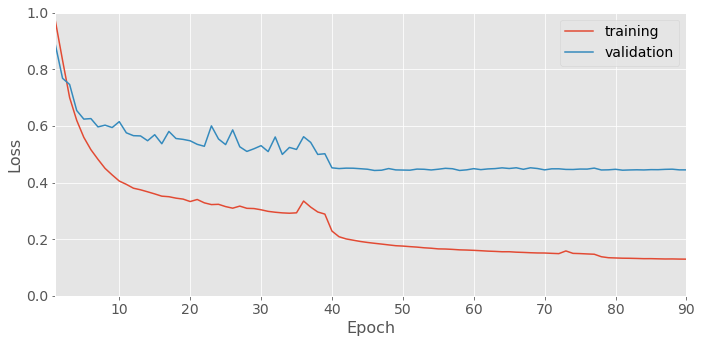

In [17]:
current_job = Job.from_name("nyu_depth_qarter_thesis")
current_job.load()
data = current_job.data

n_epochs = data["epoch"]
t_data = np.array(data["train_losses"]).squeeze()
v_data = np.array(data["val_losses"]).squeeze()    

t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)

_ = plt.figure(figsize=(10,5))
plt.plot(np.arange(n_epochs)+1, t_data, label="training")
plt.plot(np.arange(n_epochs)+1, v_data, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0,1))
plt.xlim(1, n_epochs)
plt.ylim((0,1))
plt.legend(loc='upper right')
plt.tight_layout()


plt.savefig("out/pretrain-k025.pdf", dpi=200)

## Plot some qualitative comparisons

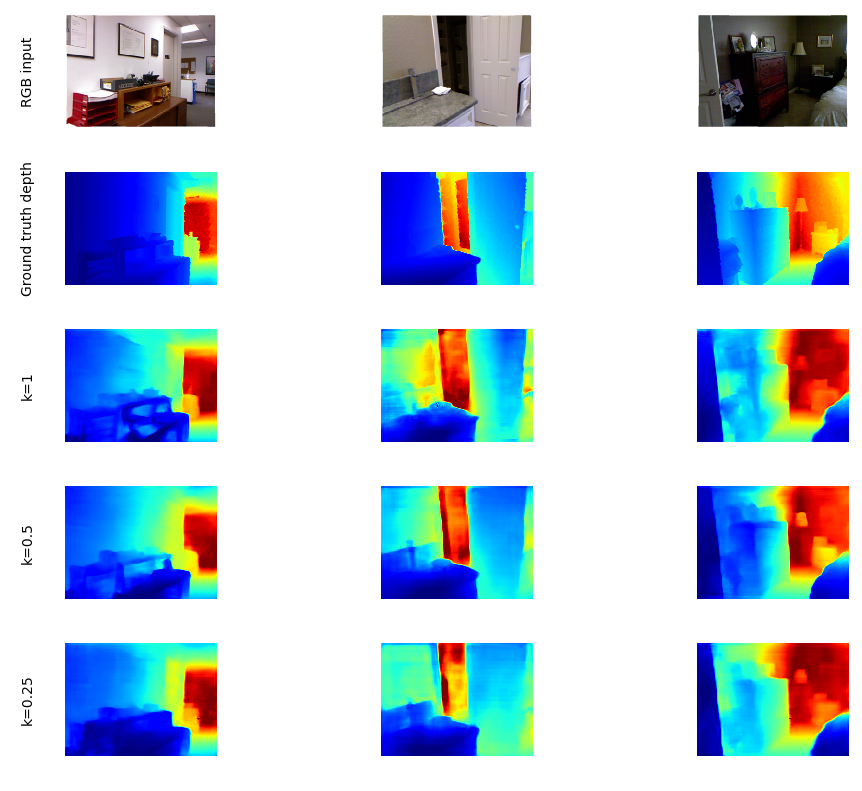

In [237]:
samples = len(cmp_indices)
plt.style.use('ggplot')
fig, ax = plt.subplots(5, samples, facecolor="white", figsize=(10,8))
for idx in range(samples):
    # Draw rgb
    ax[0][idx].imshow(draw_store_cmp[1][idx][0].squeeze().transpose((1,2,0)).astype(np.uint8))
    ax[0][idx].axis("off")
    
    ax[1][idx].imshow(draw_store_cmp[1][idx][1].squeeze(), cmap='jet')
    ax[1][idx].axis("off")
    
    ax[2][idx].imshow(draw_store_cmp[1][idx][2].squeeze(), cmap='jet')
    ax[2][idx].axis("off")
    
    ax[3][idx].imshow(draw_store_cmp[2][idx][2].squeeze(), cmap='jet')
    ax[3][idx].axis("off")
    
    ax[4][idx].imshow(draw_store_cmp[3][idx][2].squeeze(), cmap='jet')
    ax[4][idx].axis("off")
    
rows = ['RGB input', 'Ground truth depth', 'k=1', 'k=0.5', 'k=0.25']

pad = 16
for ax, row in zip(ax[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', rotation=90)
    
plt.tight_layout()
#plt.show()
plt.savefig("out/pretrain-comp.pdf", dpi=500)

## Fine-tuning

In [246]:
folds = [
    ("/data/data/resunet_f3d_half_limited_f1_thesis.npz", '/ssd/food3d/f3d-rgbd-val.hdf5'),
    ("/data/data/resunet_f3d_half_limited_f2_thesis.npz", '/ssd/food3d/f3d-rgbd-f2-val.hdf5'),
    ("/data/data/resunet_f3d_half_limited_f3_thesis.npz", '/ssd/food3d/f3d-rgbd-f3-val.hdf5')
]

In [314]:
"""
Load network and its weights
"""
global mean
mean = np.load("/ssd/food3d/f3d-train.npy")
def preprocess(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)
    
    # Extract data from combined blob
    images = images[:,0:3,:,:]
    labels = labels[:,3,:,:]

    assert images.shape[0] == labels.shape[0]
    global mean

    size = (228, 304)
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    images, labels = random_crop(images, labels, size, deterministic=True)
    images, labels = downsample(images, labels, (1, 2))
    
    # Ommit large values TODO Yes?
    labels[labels > 1.2] = 0.

    return images, labels

"""
Do the prediction for each fold
"""
cropped_depths = []
predictions = []

show_case_store = []

for model, db  in folds:       
    print "Processing fold: %s" % db
    f = h5py.File(db)
    scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True, k=0.5)
    scaffolder.compile()
    scaffolder.load(model)
    
    # Splitting is done by pre-processor
    images_loaded = np.array(f["rgbd"])
    depths_loaded = np.array(f["rgbd"])
    

            
    for index in range(images_loaded.shape[0]):
        images = images_loaded[index][np.newaxis]
        depths = depths_loaded[index][np.newaxis]
        
        # Pre process
        plt.imshow(depths[3].squeeze())
        
        images, depths = preprocess(images, depths)
        
        plt.imshow(depths.squeeze())
        break
        # Infer
        pred = scaffolder.infer(images)[0]

        # Post process
        pred = post_process_depth(pred)
        
        # For qual prints
        show_case_store.append((images_loaded[index], depths_loaded[index][3], pred))
        
        cropped_depths.append(depths)
        predictions.append(pred)
    
    break
    model_idx += 1

gt = np.concatenate(cropped_depths).squeeze()
predictions = np.concatenate(predictions).squeeze()
assert gt.shape == predictions.shape

Processing fold: /ssd/food3d/f3d-rgbd-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 11541505
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_f3d_half_limited_f1_thesis.npz'


Processing fold: /ssd/food3d/f3d-rgbd-f2-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 11541505
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_f3d_half_limited_f2_thesis.npz'


Processing fold: /ssd/food3d/f3d-rgbd-f3-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 11541505
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_f3d_half_limited_f3_thesis.npz'


In [264]:
calculate_depth_metrics(predictions, gt)

RMSE(lin)  0.217681
RMSE(log)  0.128584
Delta 1.25  0.919896836023
Delta 1.25**2  0.997712680247
Delta 1.25**3  0.999954840351
Abs rel diff  0.103471
Square rel diff  0.013213


## Qualitative Plots

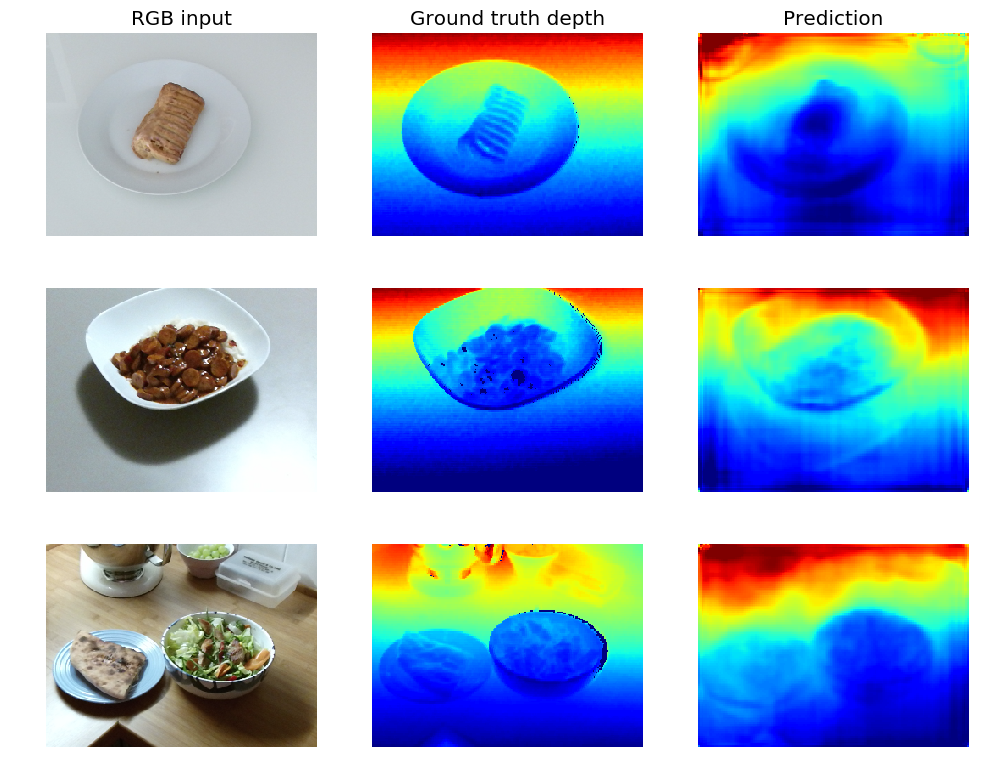

In [335]:
mpl.rcParams.update(mpl.rcParamsDefault)
show_case_indices = [12, 4561, 5897]

excerpt = [show_case_store[idx] for idx in show_case_indices]

samples = len(show_case_indices)
plt.style.use('ggplot')
fig, ax = plt.subplots(samples, 3, facecolor="white", figsize=(10,8))
for idx in range(samples):
    # Draw rgb
    ax[idx][0].imshow(excerpt[idx][0][0:3,:,:].squeeze().transpose((1,2,0)).astype(np.uint8))
    ax[idx][0].axis("off")
    
    vmin = excerpt[idx][1][excerpt[idx][1] > 0].min()
    vmax = excerpt[idx][1][excerpt[idx][1] > 0].max()
    ax[idx][1].imshow(excerpt[idx][1].squeeze(), cmap='jet', vmin=vmin, vmax=vmax)
    ax[idx][1].axis("off")
    
    ax[idx][2].imshow(excerpt[idx][2].squeeze(), cmap='jet')
    ax[idx][2].axis("off")
    
cols = ['RGB input', 'Ground truth depth', 'Prediction']

for ax, col in zip(ax[0], cols):
    ax.set_title(col)
    
plt.tight_layout()
#plt.show()
plt.savefig("out/finetune-comp.pdf", dpi=500)

## Export data for 3D Rendering

In [342]:
d = predictions - gt
m = d.mean(axis=0)
print m.argmin()

7174


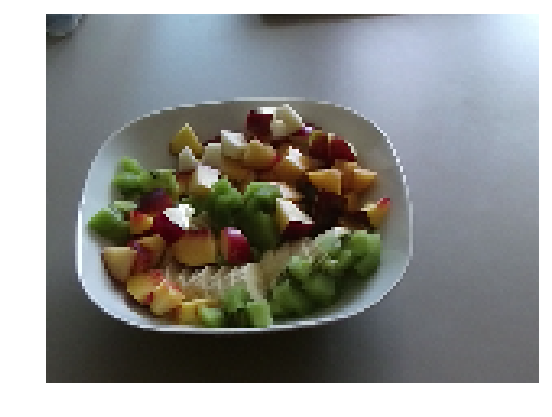

In [357]:
render_sample = 7102
depth = show_case_store[render_sample][2].squeeze().copy()
color = show_case_store[render_sample][0][0:3,6:234:2, 8:312:2].squeeze().copy()

mpl.rcParams.update(mpl.rcParamsDefault)
plt.imshow(color.transpose((1,2,0)).astype(np.uint8))
plt.axis("off")
plt.savefig("3d-image.pdf", dpi=200)

np.save("out/3d-depth.npy",depth)
np.save("out/3d-color.npy",color)

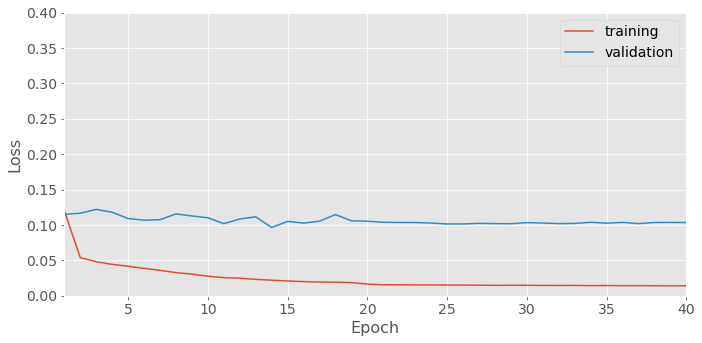

In [18]:
current_job = Job.from_name("f3d_depth_half_limited_f1_thesis")
current_job.load()
data = current_job.data

n_epochs = data["epoch"]
t_data = np.array(data["train_losses"]).squeeze()
v_data = np.array(data["val_losses"]).squeeze()    

t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)

_ = plt.figure(figsize=(10,5))
plt.plot(np.arange(n_epochs)+1, t_data, label="training")
plt.plot(np.arange(n_epochs)+1, v_data, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0,1))
plt.xlim(1, n_epochs)
plt.ylim((0,0.4))
plt.legend(loc='upper right')
plt.tight_layout()


plt.savefig("out/finetune-f1.pdf", dpi=200)

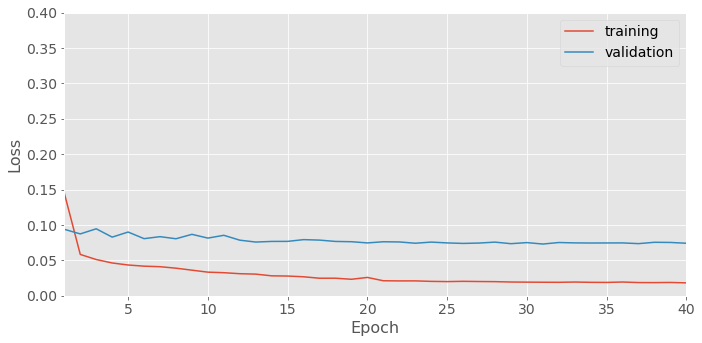

In [19]:
current_job = Job.from_name("f3d_depth_half_limited_f2_thesis")
current_job.load()
data = current_job.data

n_epochs = data["epoch"]
t_data = np.array(data["train_losses"]).squeeze()
v_data = np.array(data["val_losses"]).squeeze()    

t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)

_ = plt.figure(figsize=(10,5))
plt.plot(np.arange(n_epochs)+1, t_data, label="training")
plt.plot(np.arange(n_epochs)+1, v_data, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0,1))
plt.xlim(1, n_epochs)
plt.ylim((0,0.4))
plt.legend(loc='upper right')
plt.tight_layout()


plt.savefig("out/finetune-f2.pdf", dpi=200)

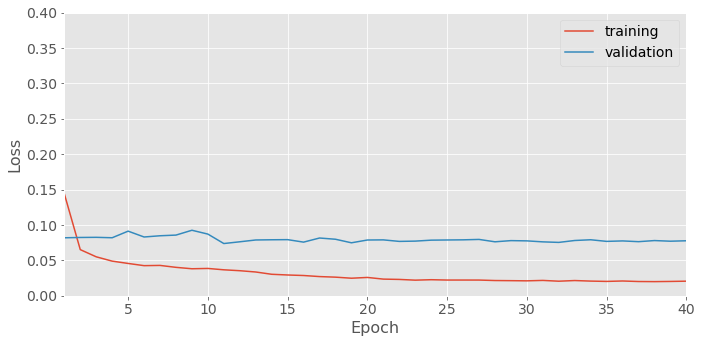

In [20]:
current_job = Job.from_name("f3d_depth_half_limited_f3_thesis")
current_job.load()
data = current_job.data

n_epochs = data["epoch"]
t_data = np.array(data["train_losses"]).squeeze()
v_data = np.array(data["val_losses"]).squeeze()    

t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)

_ = plt.figure(figsize=(10,5))
plt.plot(np.arange(n_epochs)+1, t_data, label="training")
plt.plot(np.arange(n_epochs)+1, v_data, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0,1))
plt.xlim(1, n_epochs)
plt.ylim((0,0.4))
plt.legend(loc='upper right')
plt.tight_layout()


plt.savefig("out/finetune-f3.pdf", dpi=200)

## BU Regression

### BU Regression with GT Depth data

In [360]:
"""
Setup
Preprocessor, mean etc.
"""
from coco.architectures.regression import BURegressionScaffolder, BURegressor

global mean
mean = np.load("/ssd/food3d/f3d-rgbd-train.npy")

def preprocess(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    
    size = (228, 304)
    
    global mean

    images, _ = normalize_images(images, labels, mean)
    images, _ = random_crop(images, None, size, deterministic=True)

    return images, labels

In [361]:
folds = [
    ("/data/data/bu_regressor_rgbd_f3_thesis.npz", "/ssd/food3d/f3d-rgbd-f3-val.hdf5"),
    ("/data/data/bu_regressor_rgbd_f2_thesis.npz", "/ssd/food3d/f3d-rgbd-f2-val.hdf5"),
    ("/data/data/bu_regressor_rgbd_f1_thesis.npz", "/ssd/food3d/f3d-rgbd-val.hdf5"),
]

In [362]:
original_bus = []
predictions = []

for model, db in folds:
    f = h5py.File(db)
    print "Processing fold: %s" % db
    scaffolder = BURegressionScaffolder(BURegressor, 
                                           inference=True,
                                           with_depth=True)
    scaffolder.load(model)
    scaffolder.compile()
    
    images_orig = np.array(f["rgbd"])
    bus_orig = np.array(f["bus"])
    
    for index in range(images_orig.shape[0]):
        images = images_orig[index][np.newaxis]
        bus = bus_orig[index][np.newaxis]
        
        # Pre process
        images, bus = preprocess(images, bus)
        # Infer
        pred = scaffolder.infer(images)[0]

        original_bus.append(bus)
        predictions.append(pred)

gt = np.concatenate(original_bus).squeeze()
predictions = np.concatenate(predictions).squeeze()

assert gt.shape == predictions.shape

Processing fold: /ssd/food3d/f3d-rgbd-f3-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_f3_thesis.npz'
INFO:coco.nn:Compiling inference function.


Processing fold: /ssd/food3d/f3d-rgbd-f2-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_f2_thesis.npz'
INFO:coco.nn:Compiling inference function.


Processing fold: /ssd/food3d/f3d-rgbd-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_f1_thesis.npz'
INFO:coco.nn:Compiling inference function.


In [363]:
calculate_bu_metrics(predictions, gt)

RMSE  1.49719
Abs rel diff  0.644165


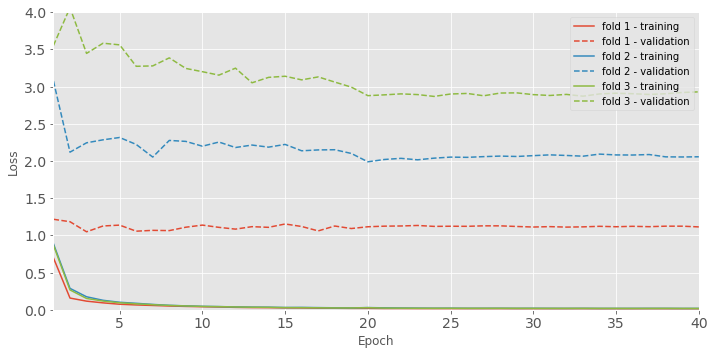

In [25]:
jobs = ["bu_regression_rgbd_f1_thesis", 
        "bu_regression_rgbd_f2_thesis",
        "bu_regression_rgbd_f3_thesis"
       ]

colors = ["#E24A33", "#348ABD", "#8EBA42"]

plt.style.use("ggplot")
_ = plt.figure(figsize=(10,5))
for idx in range(len(jobs)):
    job = jobs[idx]
    current_job = Job.from_name(job)
    current_job.load()
    data = current_job.data

    n_epochs = data["epoch"]
    t_data = np.array(data["train_losses"]).squeeze()
    v_data = np.array(data["val_losses"]).squeeze()    

    t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
    v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)


    plt.plot(np.arange(n_epochs)+1, t_data, color=colors[idx], label="fold %i - training" % (idx + 1))
    plt.plot(np.arange(n_epochs)+1, v_data, color=colors[idx], linestyle='dashed', label="fold %i - validation" % (idx + 1))


plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, n_epochs)
plt.ylim((0,4))
plt.legend(loc='upper right')
plt.tight_layout()


plt.savefig("out/bu-reg-gt.pdf", dpi=200)

### BU Regression with inferred depth

In [364]:
"""
Setup
Preprocessor, mean etc.
"""
from coco.architectures.regression import BURegressionScaffolder, BURegressor

global mean
mean = np.load("/ssd/food3d/f3d-rgbd-infer-train.npy")

def preprocess(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    
    size = (228, 304)
    
    global mean

    images, _ = normalize_images(images, labels, mean)
    images, _ = random_crop(images, None, size, deterministic=True)

    return images, labels

In [365]:
folds = [
    ("/data/data/bu_regressor_rgbd_infer_f3_thesis.npz", "/ssd/food3d/f3d-rgbd-f3-crossval-infer-val.hdf5"),
    ("/data/data/bu_regressor_rgbd_infer_f2_thesis.npz", "/ssd/food3d/f3d-rgbd-f2-crossval-infer-val.hdf5"),
    ("/data/data/bu_regressor_rgbd_infer_f1_thesis.npz", "/ssd/food3d/f3d-rgbd-crossval-infer-val.hdf5"),
]

In [366]:
original_bus = []
predictions = []

for model, db in folds:
    f = h5py.File(db)
    print "Processing fold: %s" % db
    scaffolder = BURegressionScaffolder(BURegressor, 
                                           inference=True,
                                           with_depth=True)
    scaffolder.load(model)
    scaffolder.compile()
    
    images_orig = np.array(f["rgbd"])
    bus_orig = np.array(f["bus"])
    
    for index in range(images_orig.shape[0]):
        images = images_orig[index][np.newaxis]
        bus = bus_orig[index][np.newaxis]
        
        # Pre process
        images, bus = preprocess(images, bus)
        # Infer
        pred = scaffolder.infer(images)[0]

        original_bus.append(bus)
        predictions.append(pred)

gt = np.concatenate(original_bus).squeeze()
predictions = np.concatenate(predictions).squeeze()

assert gt.shape == predictions.shape

Processing fold: /ssd/food3d/f3d-rgbd-f3-crossval-infer-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_infer_f3_thesis.npz'
INFO:coco.nn:Compiling inference function.


Processing fold: /ssd/food3d/f3d-rgbd-f2-crossval-infer-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_infer_f2_thesis.npz'
INFO:coco.nn:Compiling inference function.


Processing fold: /ssd/food3d/f3d-rgbd-crossval-infer-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23513217
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgbd_infer_f1_thesis.npz'
INFO:coco.nn:Compiling inference function.


In [367]:
calculate_bu_metrics(predictions, gt)

RMSE  1.46819
Abs rel diff  0.61317


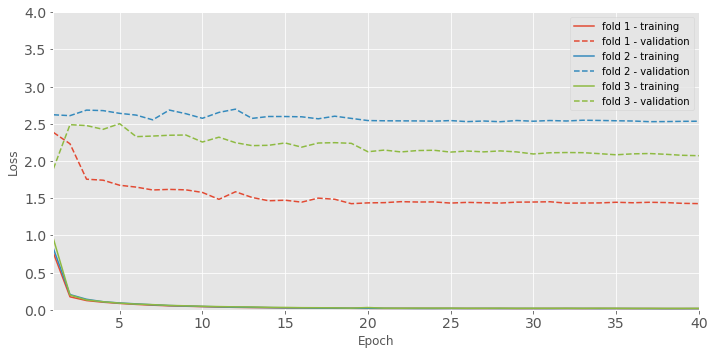

In [26]:
jobs = ["bu_regression_rgbd_infer_f1_thesis", 
        "bu_regression_rgbd_infer_f2_thesis",
        "bu_regression_rgbd_infer_f3_thesis"
       ]

colors = ["#E24A33", "#348ABD", "#8EBA42"]

plt.style.use("ggplot")
_ = plt.figure(figsize=(10,5))
for idx in range(len(jobs)):
    job = jobs[idx]
    current_job = Job.from_name(job)
    current_job.load()
    data = current_job.data

    n_epochs = data["epoch"]
    t_data = np.array(data["train_losses"]).squeeze()
    v_data = np.array(data["val_losses"]).squeeze()    

    t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
    v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)


    plt.plot(np.arange(n_epochs)+1, t_data, color=colors[idx], label="fold %i - training" % (idx + 1))
    plt.plot(np.arange(n_epochs)+1, v_data, color=colors[idx], linestyle='dashed', label="fold %i - validation" % (idx + 1))


plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, n_epochs)
plt.ylim((0,4))
plt.legend(loc='upper right')
plt.tight_layout()


plt.savefig("out/bu-reg-inf.pdf", dpi=200)

### BU Regression RGB only

In [368]:
global mean
mean = np.load("/ssd/food3d/f3d-train.npy")

def preprocess(images, labels):
    images = images.astype(np.float32)
    images = images[:,0:3,:,:]
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]

    size = (228, 304)
    
    global mean
    
    images, _ = normalize_images(images, labels, mean)
    images, _ = random_crop(images, None, size)
    
    return images, labels

In [369]:
folds = [
    ("/data/data/bu_regressor_rgb_only_f3_thesis.npz", "/ssd/food3d/f3d-rgbd-f3-val.hdf5"),
    ("/data/data/bu_regressor_rgb_only_f2_thesis.npz", "/ssd/food3d/f3d-rgbd-f2-val.hdf5"),
    ("/data/data/bu_regressor_rgb_only_f1_thesis.npz", "/ssd/food3d/f3d-rgbd-val.hdf5"),
]

In [370]:
original_bus = []
predictions = []

for model, db in folds:
    f = h5py.File(db)
    print "Processing fold: %s" % db
    scaffolder = BURegressionScaffolder(BURegressor, 
                                           inference=True,
                                           with_depth=False)
    scaffolder.load(model)
    scaffolder.compile()
    
    images_orig = np.array(f["rgbd"])
    bus_orig = np.array(f["bus"])
    
    for index in range(images_orig.shape[0]):
        images = images_orig[index][np.newaxis]
        bus = bus_orig[index][np.newaxis]
        
        # Pre process
        images, bus = preprocess(images, bus)
        # Infer
        pred = scaffolder.infer(images)[0]

        original_bus.append(bus)
        predictions.append(pred)

gt = np.concatenate(original_bus).squeeze()
predictions = np.concatenate(predictions).squeeze()

assert gt.shape == predictions.shape

Processing fold: /ssd/food3d/f3d-rgbd-f3-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23510081
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgb_only_f3_thesis.npz'
INFO:coco.nn:Compiling inference function.


Processing fold: /ssd/food3d/f3d-rgbd-f2-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23510081
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgb_only_f2_thesis.npz'
INFO:coco.nn:Compiling inference function.


Processing fold: /ssd/food3d/f3d-rgbd-val.hdf5


INFO:coco.nn:Number of parameters for output 'None': 23510081
INFO:coco.nn:Loading parameters from file '/data/data/bu_regressor_rgb_only_f1_thesis.npz'
INFO:coco.nn:Compiling inference function.


In [371]:
calculate_bu_metrics(predictions, gt)

RMSE  1.4406
Abs rel diff  0.635817


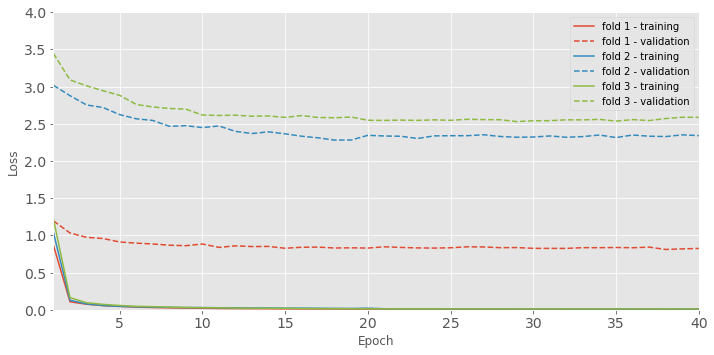

In [27]:
jobs = ["bu_regression_rgb_only_thesis_f1", 
        "bu_regression_rgb_only_thesis_f2",
        "bu_regression_rgb_only_thesis_f3"
       ]

colors = ["#E24A33", "#348ABD", "#8EBA42"]

plt.style.use("ggplot")
_ = plt.figure(figsize=(10,5))
for idx in range(len(jobs)):
    job = jobs[idx]
    current_job = Job.from_name(job)
    current_job.load()
    data = current_job.data

    n_epochs = data["epoch"]
    t_data = np.array(data["train_losses"]).squeeze()
    v_data = np.array(data["val_losses"]).squeeze()    

    t_data = np.array(np.split(t_data, n_epochs)).mean(axis=1)
    v_data = np.array(np.split(v_data, n_epochs)).mean(axis=1)


    plt.plot(np.arange(n_epochs)+1, t_data, color=colors[idx], label="fold %i - training" % (idx + 1))
    plt.plot(np.arange(n_epochs)+1, v_data, color=colors[idx], linestyle='dashed', label="fold %i - validation" % (idx + 1))


plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, n_epochs)
plt.ylim((0,4))
plt.legend(loc='upper right')
plt.tight_layout()


plt.savefig("out/bu-reg-rgb-only.pdf", dpi=200)

# Supplementary code, run this first

In [2]:
"""
Get coco lib in here
"""
import sys
import os
import inspect
import h5py
import time
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)



In [3]:
from coco.job import Job
Job.set_job_dir("/data/coco-jobs-relocated")

In [24]:
"""
Matplotlib and stuff
"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
import numpy as np
import time

In [5]:
def rmse(prediction, gt):
    assert prediction.shape == gt.shape
    d = gt - prediction
    rmse = np.sqrt((d**2).mean())
    return rmse


def rmse_log(prediction, gt):
    assert prediction.shape == gt.shape
    d = np.log(gt) - np.log(prediction)
    d = d[gt > 0]
    rmse = np.sqrt((d**2).mean())
    return rmse


def threshold(prediction, gt, thresh):
    assert prediction.shape == gt.shape
    a = prediction / gt
    b = gt / prediction
    elementwise_maximum = np.maximum(a, b)
    elementwise_maximum = elementwise_maximum[gt > 0]
    
    ones = np.ones_like(elementwise_maximum, dtype=np.float32)
    total = np.sum(ones)
    
    # Set non-satisfying elements to 0
    ones[elementwise_maximum < thresh] = 0
    satisfy = total - np.sum(ones)
    return float(satisfy)/float(total)


def abs_rel_diff(prediction, gt):
    assert prediction.shape == gt.shape
    diff = abs(prediction - gt)
    diff = diff[gt > 0]
    gt = gt[gt > 0]
    return np.mean(diff/gt)


def square_rel_diff(prediction, gt):
    assert prediction.shape == gt.shape
    diff = (prediction - gt)**2
    diff = diff[gt > 0]
    gt = gt[gt > 0]
    return np.mean(diff/gt)
    

In [6]:
def post_process_depth(depth):
    upper = np.percentile(depth, 99)
    lower = np.percentile(depth, 1)
    depth = depth.clip(lower, upper)
    return depth

In [7]:
def calculate_depth_metrics(pred, gt):
    assert pred.shape == gt.shape
    r = rmse(pred, gt)
    print "RMSE(lin) ", r
    
    r = rmse_log(pred, gt)
    print "RMSE(log) ", r
    
    r = threshold(pred, gt, 1.25)
    print "Delta 1.25 ", r
    
    r = threshold(pred, gt, 1.25**2)
    print "Delta 1.25**2 ", r
    
    r = threshold(pred, gt, 1.25**3)
    print "Delta 1.25**3 ", r
    
    r = abs_rel_diff(pred, gt)
    print "Abs rel diff ", r
    
    r = square_rel_diff(pred, gt)
    print "Square rel diff ", r
    
    
    
def calculate_bu_metrics(pred, gt):
    assert pred.shape == gt.shape
    r = rmse(pred, gt)
    print "RMSE ", r
    r = abs_rel_diff(pred, gt)
    print "Abs rel diff ", r